**Make sure to include** `import allow_local_imports` on top of every notebook in `notebooks/` dir to be able to use `lib/` modules.

In [1]:
# Include this on top, as the first import 
# This must always be imported first. If you are restarting the notebook
# don't forget to run this cell first!
import allow_local_imports

In [3]:
from lib.minority_game import MinorityGame
from lib.agents.agent import Agent, StrategyUpdatingAgent
from lib.agents.factory import AgentFactory
from lib.strategies import AlwaysOneStrategy, DefaultStrategy, FiftyFiftyStrategy
from lib.memory import UniformMemoryGenerator
from lib.plots import default_plot

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma
import seaborn as sns
from numpy.random import default_rng

In [20]:
class BaseMemoryGenerator:
    """
    Abstract class that should be subclassed when implementing
    a new memory generator.
    """
    def __init__(self, m):
        self.m = m

    def generate(self, size):
        raise NotImplementedError


class UniformMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a uniform distribution.
    (All memories are of equal length...)
    """

    def generate(self, size):
        return np.ones(size, dtype=np.int32) * self.m
    
class NormalDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a distribution
    (Memories are distributed by normal distribution.)
    """

    def generate(self, size):
        rng = default_rng()
        return rng.normal(self.m, 0.5, size).astype(int)
    
class GaussianDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a distribution
    (Memories are distributed by default gaussian distribution.)
    """

    def generate(self, n_agents, min_m = 1, max_m = 20, a = 4):
        spaces = max_m-min_m+1
        x = np.linspace(min_m, max_m, spaces)
        y =  gamma.pdf(x, a)
        sample = np.random.choice(x, n_agents, p=y/(sum(y))).astype(int)
        return sample

class GumbelDistributionMemoryGenerator(BaseMemoryGenerator):
    """
    Samples memory from a gumbel distribution.
    (Skwed distribution of memory)
    """

    def generate(self, size):
        rng = default_rng()
        return rng.gumbel(self.m, 0.5, size).astype(int)   

## Simple MG (s = 2, N = 101, uniform memory)

In [24]:
n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega_u = []
tot_alpha_u = []

for M in range (2,10):
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=UniformMemoryGenerator(M)
            ),
        }
    ).simulate_game(max_steps=5000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega_u.append(omega)
    tot_alpha_u.append(alpha)

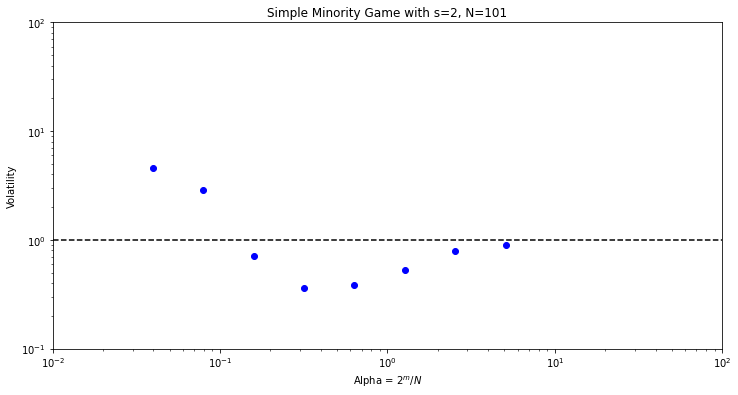

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_u, tot_omega_u, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("Simple Minority Game with s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## MG (s = 2, N = 101, gumbel distribution memory)

/Users/Luca/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


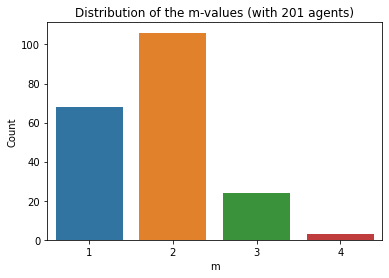

In [44]:
# a possible distribution 
rng = default_rng()
m = 2
n_agents = 201

a = rng.gumbel(m, 0.5, n_agents).astype(int) # m is the mode , 1 is the scale (how narrow it is), n_agents is the size

# Numpy arrays containing counts for each side
side, count = np.unique(a, return_counts=True)

# Plot the results
sns.barplot(side, count)
plt.title(
    f"Distribution of the m-values (with {n_agents} agents)")
plt.ylabel("Count")
plt.xlabel("m")
plt.show()

In [14]:
n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega_g = []
tot_alpha_g = []

for M in range (2,10):
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=GumbelDistributionMemoryGenerator(M)
            ),
        }
    ).simulate_game(max_steps=5000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega_g.append(omega)
    tot_alpha_g.append(alpha)

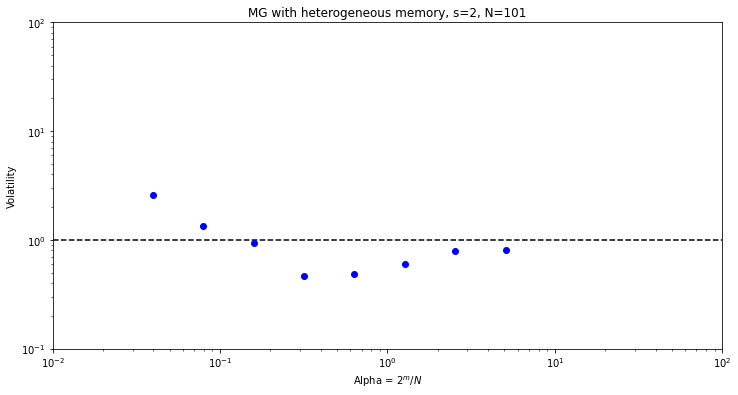

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_g, tot_omega_g, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## MG (s = 2, N = 101, normal distribution memory)

/Users/Luca/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


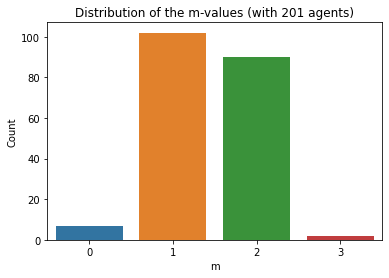

In [43]:
# problem it should not give 0 value
rng = default_rng()
m = 2
n_agents = 201

a = rng.normal(m, 0.5, n_agents).astype(int) # m is the mode , 1 is the scale (how narrow it is), n_agents is the size

# Numpy arrays containing counts for each side
side, count = np.unique(a, return_counts=True)

# Plot the results
sns.barplot(side, count)
plt.title(
    f"Distribution of the m-values (with {n_agents} agents)")
plt.ylabel("Count")
plt.xlabel("m")
plt.show()

In [19]:
n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega_n = []
tot_alpha_n = []

for M in range (3,10): # with 2 some agents have memory of 0 wich does not make sense
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=NormalDistributionMemoryGenerator(M)
            ),
        }
    ).simulate_game(max_steps=5000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega_n.append(omega)
    tot_alpha_n.append(alpha)

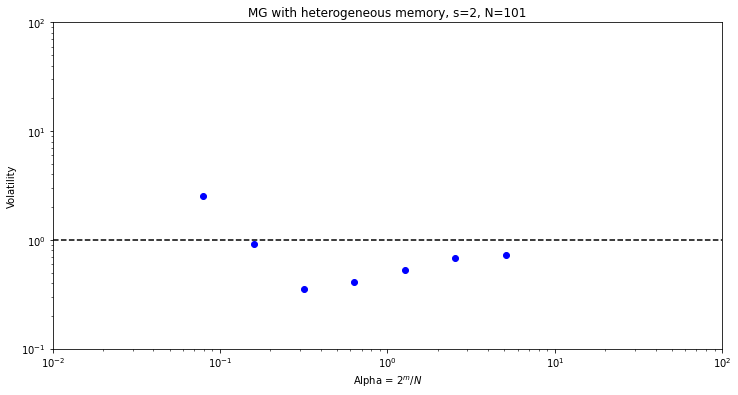

In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(tot_alpha_n, tot_omega_n, 'bo')
ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility")

plt.title("MG with heterogeneous memory, s=2, N=101")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## Everything in one graph

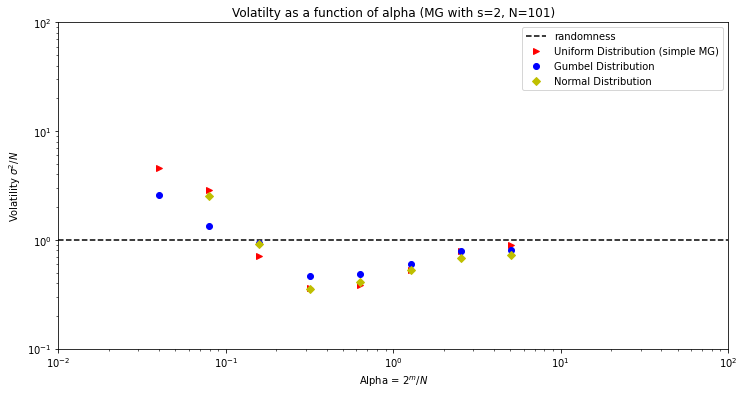

In [27]:
# everything in one graph

fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--") # vol = 1 -> randomness

ax.plot(tot_alpha_u, tot_omega_u, '>r')
ax.plot(tot_alpha_g, tot_omega_g, 'bo')
ax.plot(tot_alpha_n, tot_omega_n, 'Dy')

ax.set_xlabel("Alpha = $2^m/N$")
ax.set_ylabel("Volatility $\sigma^2/N$")
ax.legend(["randomness","Uniform Distribution (simple MG)","Gumbel Distribution", "Normal Distribution"])

plt.title("Volatilty as a function of alpha (MG with s=2, N=101)")
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.01,100])
plt.ylim([0.1,100])

plt.show()

## Check for variation in realization (should we do multiple realization for each value of alpha?)

In [36]:
# normal distribution

n_agents = 101 # check with David why it does not work if I do MinorityGame.n_agents
tot_omega = []
tot_alpha = []
realization = []
M = 5
for i in range (0,10): 
    times, attendances, mean_A_t, vol_A_t = MinorityGame(
        n_agents=101,
        factory_dict={
            1: AgentFactory(
                Agent,
                agent_kwargs=dict(
                    strategy_clss=[DefaultStrategy,DefaultStrategy]
                ),
                memory_generator=NormalDistributionMemoryGenerator(M)
            ),
        }
    ).simulate_game(max_steps=5000)
    # in order to create the graph
    omega = np.average(vol_A_t)/n_agents
    alpha = 2**M/n_agents
    tot_omega.append(omega)
    tot_alpha.append(alpha)
    realization.append(i)

In [40]:
realization

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

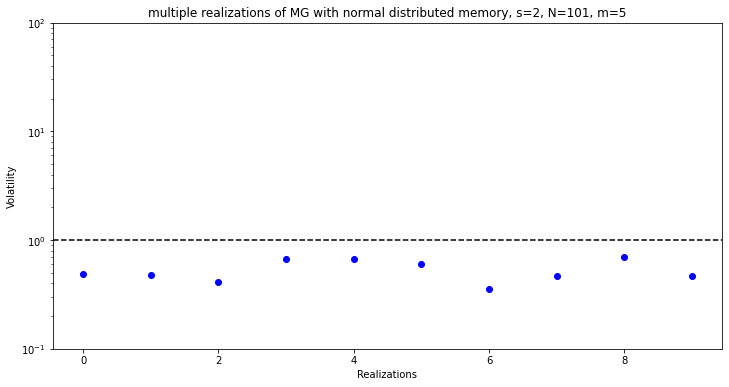

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.axhline(y=1, color="k", linestyle="--")
ax.plot(realization, tot_omega, 'bo')
ax.set_xlabel("Realizations")
ax.set_ylabel("Volatility")

plt.title("multiple realizations of MG with normal distributed memory, s=2, N=101, m=5")
plt.yscale('log')
plt.ylim([0.1,100])

plt.show()

There is some variation within realizations...